In [1]:
# Import libraries
import math
import pandas_datareader as web
import  numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')
import numpy as np
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
# Description: This program predicts the price of Bitcoin for the next 30 days


In [3]:

import pandas_datareader.data as web
import datetime    
start = datetime.datetime(2012, 1, 3)
end = datetime.datetime(2021, 4, 15)
df = web.DataReader("BTC-USD", 'yahoo', start, end)

dates =[]
for x in range(len(df)):
    newdate = str(df.index[x])
    newdate = newdate[0:10]
    dates.append(newdate)

df['date'] = dates


RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/BTC-USD/history?period1=1325556000&period2=1618538399&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [ ]:
df.reset_index(inplace=True,drop=False)

In [ ]:
df['Date']

In [ ]:
df



In [ ]:
df.head(7)



In [9]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])




In [10]:
#Variables for training
# cols = list(df)[0:1]


In [11]:
#Variables for training
cols = list(df)[1:6]

In [12]:
cols

['High', 'Low', 'Open', 'Close', 'Volume']

In [13]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

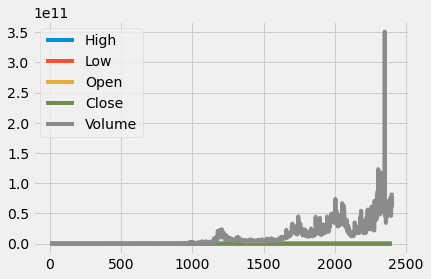

In [14]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [15]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)

df_for_training_scaled = scaler.transform(df_for_training)



In [16]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

trainX = []
trainY = []

In [17]:
n_future = 1 # Number of days we want to predict into the future
n_past = 150 # Number of past days we want to use to predict the future


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (2250, 150, 5).
trainY shape == (2250, 1).


In [18]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 64)           17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)



Epoch 1/10
127/127 [==============================] - 17s 107ms/step - loss: 0.0523 - val_loss: 410.0523
Epoch 2/10
127/127 [==============================] - 13s 105ms/step - loss: 0.0120 - val_loss: 123.3351
Epoch 3/10
127/127 [==============================] - 13s 105ms/step - loss: 0.0108 - val_loss: 34.6661
Epoch 4/10
127/127 [==============================] - 13s 106ms/step - loss: 0.0092 - val_loss: 5158.3638
Epoch 5/10
127/127 [==============================] - 13s 106ms/step - loss: 0.0109 - val_loss: 49698.6484
Epoch 6/10
127/127 [==============================] - 14s 107ms/step - loss: 0.0081 - val_loss: 419.9550
Epoch 7/10
127/127 [==============================] - 14s 106ms/step - loss: 0.0076 - val_loss: 0.1762
Epoch 8/10
127/127 [==============================] - 14s 108ms/step - loss: 0.0073 - val_loss: 0.2039
Epoch 9/10
127/127 [==============================] - 14s 108ms/step - loss: 0.0082 - val_loss: 0.3185
Epoch 10/10
127/127 [==============================] - 14s 

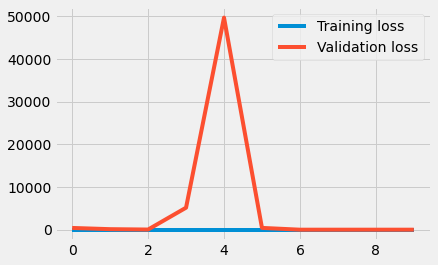

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [21]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future= 150 #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

In [22]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


In [23]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


<ipython-input-24-36b5c3f76479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/home/thembajsph/Downloads/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thembajsph/Downloads/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

<AxesSubplot:xlabel='Date', ylabel='Close'>

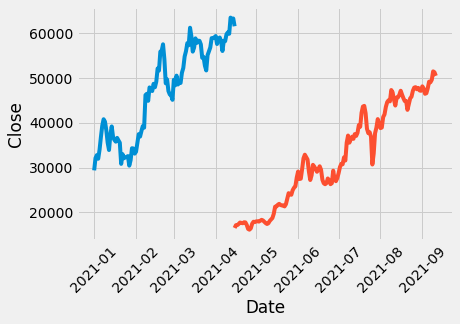

In [24]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-1-1']
plt.xticks(rotation=45)

sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

In [44]:
df_forecast.head(42)


,Date,Close
0,2021-04-15,16508.361328
1,2021-04-16,17135.283203
2,2021-04-17,17140.599609
3,2021-04-18,17393.201172
4,2021-04-19,17715.755859
5,2021-04-20,17630.564453
6,2021-04-21,17561.410156
7,2021-04-22,17776.873047
8,2021-04-23,17749.984375
9,2021-04-24,17174.457031


In [26]:
#Description: This program uses the Moving Average Convergence/Divergence (MACD) crossover
#             to determine when to buy and sell stock.


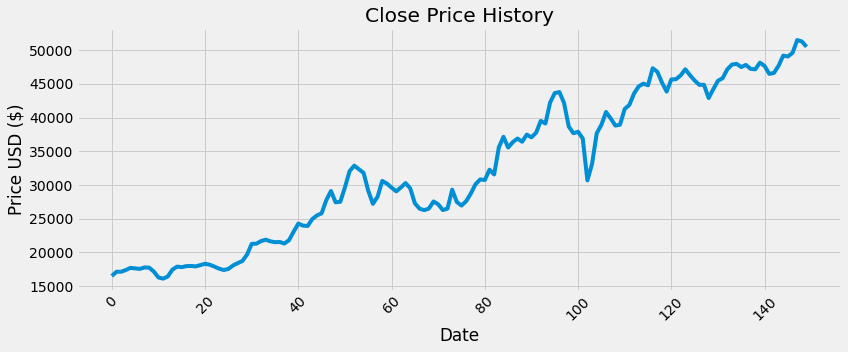

In [27]:
#Visually show the stock price 
plt.figure(figsize=(12.2, 4.5))
plt.plot(df_forecast['Close'], label='Close')
plt.xticks(rotation=45)
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()

In [28]:
#Prepare the data to calculate the RSI

#First get the difference in price from the previous day
delta = df_forecast['Close'].diff(1)

delta

0              NaN
1       626.921875
2         5.316406
3       252.601562
4       322.554688
          ...     
145    -131.644531
146     542.632812
147    1895.605469
148    -207.628906
149    -794.238281
Name: Close, Length: 150, dtype: float32

In [29]:
#Get rii NaN
delta = delta.dropna()
delta

1       626.921875
2         5.316406
3       252.601562
4       322.554688
5       -85.191406
          ...     
145    -131.644531
146     542.632812
147    1895.605469
148    -207.628906
149    -794.238281
Name: Close, Length: 149, dtype: float32

In [30]:
#Get the positive gains(up) and the negative gains (down)
up = delta.copy()
down = delta.copy()

up[up <0 ]= 0
down[down > 0] = 0

In [31]:
#Get the time period
period = 14
#Calculate the avarage gain and the average loss
AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = abs(down.rolling(window=period).mean())



In [32]:
#Calculate the RSI

#Calculate the Relative Strength (RS)
RS = AVG_Gain / AVG_Loss

#Calculate the Relative Strength Index (RSI)
RSI = 100.0 - (100.0 / (1.0 + RS))

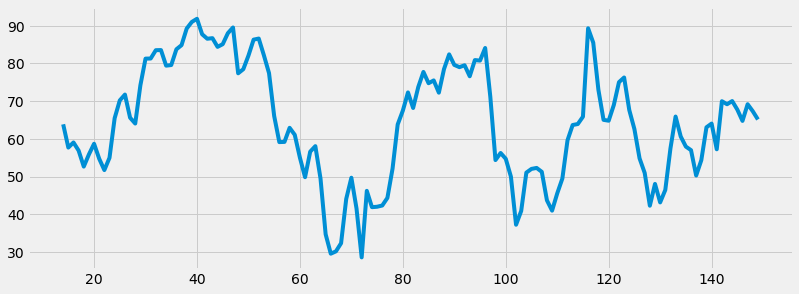

In [33]:
#Show the RSI Visually
plt.figure(figsize=(12.2, 4.5))
RSI.plot()
plt.show()

In [34]:
#Put it all together

#Create a new data frame
new_df = pd.DataFrame()
new_df['Close'] = df_forecast['Close']
new_df['RSI'] = RSI
new_df.head(41)

,Close,RSI
0,16508.361328,NaN
1,17135.283203,NaN
2,17140.599609,NaN
3,17393.201172,NaN
4,17715.755859,NaN
5,17630.564453,NaN
6,17561.410156,NaN
7,17776.873047,NaN
8,17749.984375,NaN
9,17174.457031,NaN


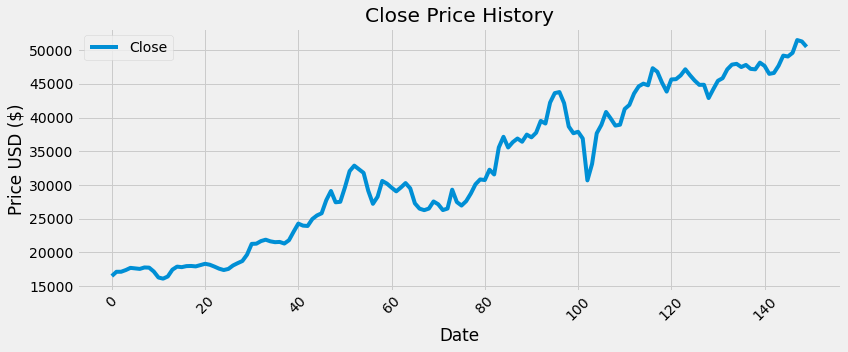

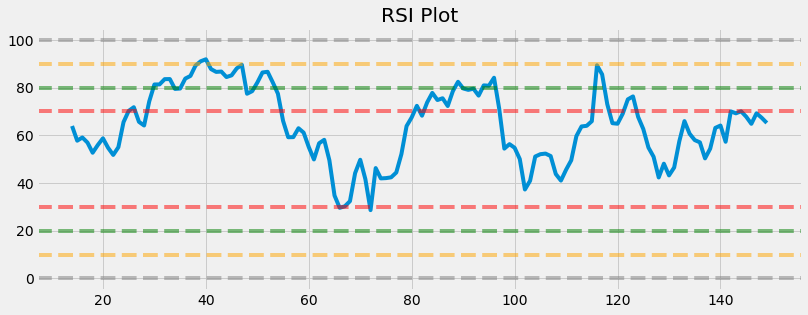

In [35]:
#Visually show the adj Close Price and RSI

#Plot the adjusted close price
plt.figure(figsize=(12.2, 4.5))
plt.plot(new_df.index, new_df['Close'], label='Close')
plt.xticks(rotation=45)
plt.title('Close Price History')
plt.legend(new_df.columns.values, loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()
#Plot the corrresponding RSI values and significant levels
plt.figure(figsize=(12.2, 4.5))
plt.title('RSI Plot')
plt.plot(new_df.index, new_df['RSI'])
plt.axhline(0, linestyle= '--', alpha = 0.5, color= 'gray')
plt.axhline(10, linestyle= '--', alpha = 0.5, color= 'orange')
plt.axhline(20, linestyle= '--', alpha = 0.5, color= 'green')
plt.axhline(30, linestyle= '--', alpha = 0.5, color= 'red')
plt.axhline(70, linestyle= '--', alpha = 0.5, color= 'red')
plt.axhline(80, linestyle= '--', alpha = 0.5, color= 'green')
plt.axhline(90, linestyle= '--', alpha = 0.5, color= 'orange')
plt.axhline(100, linestyle= '--', alpha = 0.5, color= 'gray')
plt.show()